# Backtesting class for Simple Moving Average

We create a class in order to automate all the trading strategies we saw in the [previous notebook](https://github.com/alecontuIT/algo_trading_coletti/blob/main/4_moving_averages_crossovers.ipynb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from itertools import product
from seaborn import heatmap

In [24]:
class SMABacktester():
    '''Class for backtesting of simple moving average trading strategies.'''
    
    def __init__(self, ticker, SMA_s, SMA_l, start, end):
        '''
        Parameters
        ----------
        ticker: str
            String of the asset's ticker of Yahoo Finance
        SMA_s: int
            Window for the short SMA
        SMA_l: int
            Window for the long SMA
        start: str
            Starting date to get the data, format 'YYYY-MM-DD'
        end: str
            Ending date to get the data, format 'YYYY-MM-DD'
        '''
        self._ticker = ticker
        self._SMA_s = SMA_s
        self._SMA_l = SMA_l
        self._start = start
        self._end = end
        self.get_data()
        self.prepare_data()
        self.results = None
        
    def get_data(self):
        '''
        Get the asset data using Yahoo Finance API, then compute the logReturn.
        '''
        df = yf.download(ticker, start, end)['Adj Close'].to_frame()
        df.dropna(inplace=True)
        df['logRet'] = np.log(df/df.shift(1))
        self.data = df
    
    def prepare_data(self):
        '''
        Add the short SMA and long SMA columns to the dataframe
        '''
        self.data['SMA_s'] = self.data['Adj Close'].rolling(self._SMA_s).mean()
        self.data['SMA_l'] = self.data['Adj Close'].rolling(self._SMA_l).mean()
        
    def set_parameters(self, SMA_s=None, SMA_l=None):
        '''
        Set a new window for short SMA, long SMA or both.
        
        Parameters
        ----------
        SMA_s: int
            Window for the short SMA
        SMA_l: int
            Window for the long SMA
        '''
        if SMA_s is not None:
            self._SMA_s = SMA_s
            self.data['SMA_s'] = self.data['Adj Close'].rolling(self._SMA_s).mean()
        if SMA_s is not None:
            self._SMA_l = SMA_l
            self.data['SMA_l'] = self.data['Adj Close'].rolling(self._SMA_l).mean()
            
    def test_strategy(self):
        '''
        Test SMA trading strategy
        '''
        data = self.data.copy().dropna()
        data['position'] = np.where(data.SMA_s>data.SMA_l, 1, -1)
        data['gain'] = data.position.shift(1) * data.logRet
        data.dropna(inplace=True)
        data['cumLogRet'] = data.logRet.cumsum()
        data['cumGain'] = data.gain.cumsum()
        # SMA trading strategy performance
        performance = data.cumGain.iloc[-1]
        # Difference of performance of our trading strategy, compared to buy-and-hold
        outPerformance = data.cumGain.iloc[-1] - data.cumLogRet.iloc[-1]
        # Maximum drawdown value
        maxDrawdown = (data.cumGain.cummax() - data.cumGain).max()
        self.results = data
        # We are using logReturns, for this reason if we want the real return we must elevate
        # the difference with the exponential
        # With the exponantial we can know how much we gain from 1€ invested
        return round(performance, 6), round(outPerformance, 6), round(maxDrawdown, 6)
    
    def plot_results(self):
        '''
        Plot the cumulative log-return time series and the cumulative gain of our trading strategy
        '''
        assert self.results is not None, 'You must run test_strategy() before'
        
        title = '{}  SMA_s = {}  SMA_l = {}'.format(self._ticker, self._SMA_s, self._SMA_l)
        self.results[['cumLogRet','cumGain']].plot(figsize=(14,8))
        plt.legend(fontsize=18)
        plt.title(title, fontsize=22)
        
    def optimize_parameters(self, SMA_s_range, SMA_l_range):
        '''
        Find the best short and long windows parameters that maximize the gain.
        
        Parameters
        ----------
        SMA_s_range: Tuple
            Tuple with min and max value of window range for short SMA
        SMA_l_range: Tuple
            Tuple with min and max value of window range for long SMA
        '''
        combinations = list(product(range(*SMA_s_range), range(*SMA_l_range)))
        performance_results = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            performance_results.append(self.test_strategy()[0])
        
        bestPerformance = np.max(performance_results)
        bestParameters = combinations[np.argmax(performance_results)]
        
        self.set_parameters(bestParameters[0], bestParameters[1])
        self.test_strategy()
        
        allResults = pd.DataFrame(combinations, columns=['SMA_s', 'SMA_l'])
        allResults['performance'] = performance_results
        self.resultsOverview = allResults
        self.plot_parameters_heatmap(allResults)
        return bestParameters, bestPerformance
    
    def plot_parameters_heatmap(self, allResults):
        '''
        Plot the heatmap of the short and long SMA windows performance.
        '''
        # Create a table to plot the heatmap
        allResultsTable = allResults.pivot(index='SMA_s', columns='SMA_l', values='performance')
        plt.figure(figsize=(15,10))
        plt.title('SMA windows performance')
        heatmap(allResultsTable, cmap='Reds')

In [25]:
ticker = 'EURUSD=X'
SMA_s = 50
SMA_l = 200
start = '2008-10-01'
end = '2021-10-01'

tester = SMABacktester(ticker, SMA_s, SMA_l, start, end)

[*********************100%%**********************]  1 of 1 completed


In [26]:
tester.test_strategy()

(0.043937, 0.225829, 0.291806)

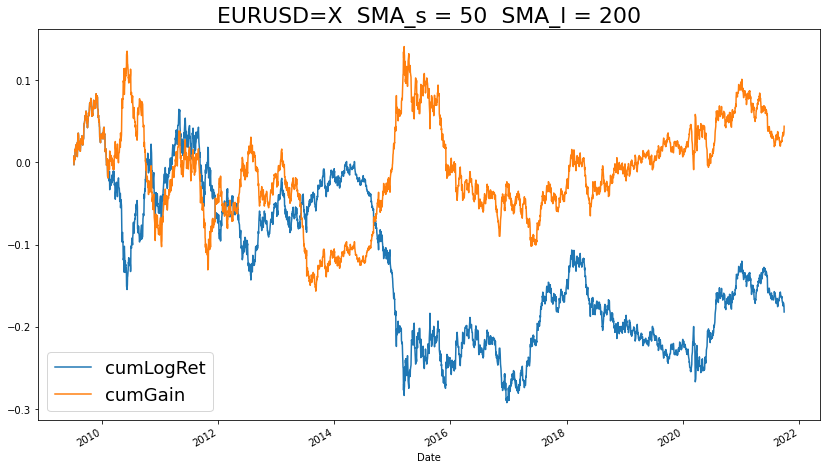

In [27]:
tester.plot_results()

((38, 127), 0.60463)

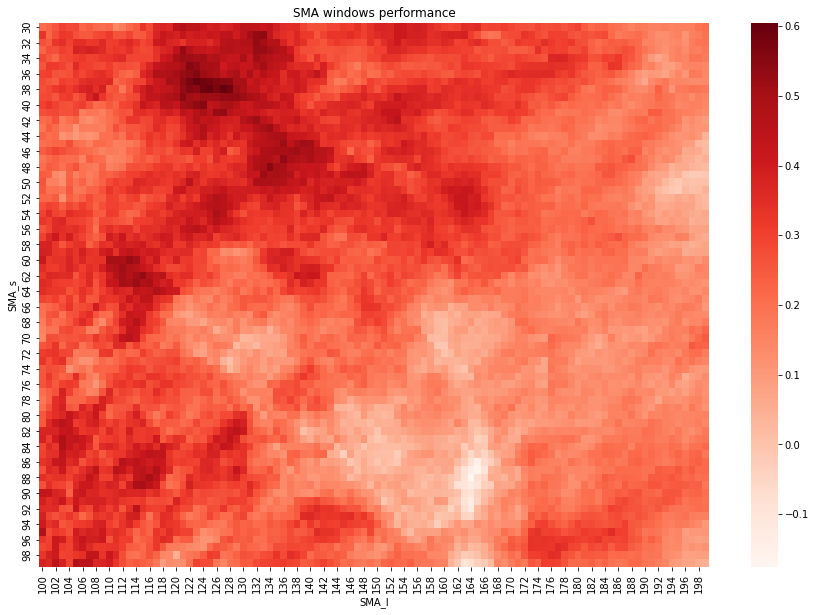

In [28]:
SMA_s_range = (30,100)
SMA_l_range = (100, 200)
tester.optimize_parameters(SMA_s_range, SMA_l_range)

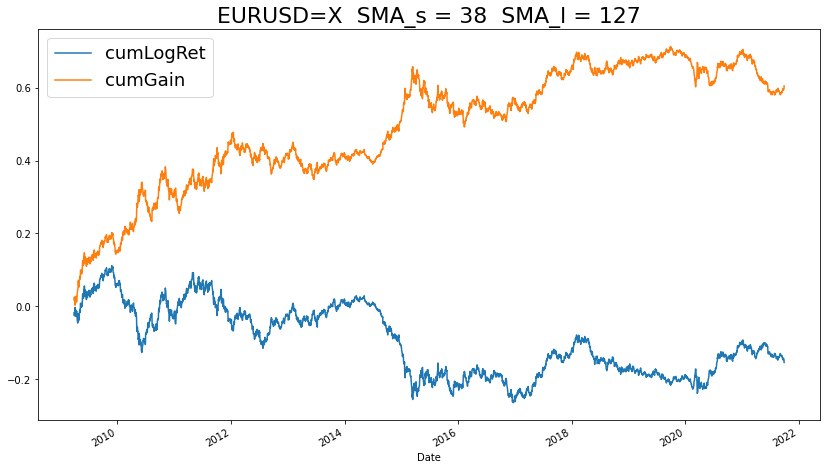

In [29]:
tester.plot_results()